# Scene Text Detection:

## 1. Description

With the rise and development of deep learning, computer vision has been tremendously transformed and reshaped.<br>
As an important research area in computer vision, scene text detection and recognition hasbeen inevitably influenced by this wave of revolution, consequentially entering the era of deep learning.<br> 
In recent years, the community has witnessed substantial advancements in mindset, methodology and performance

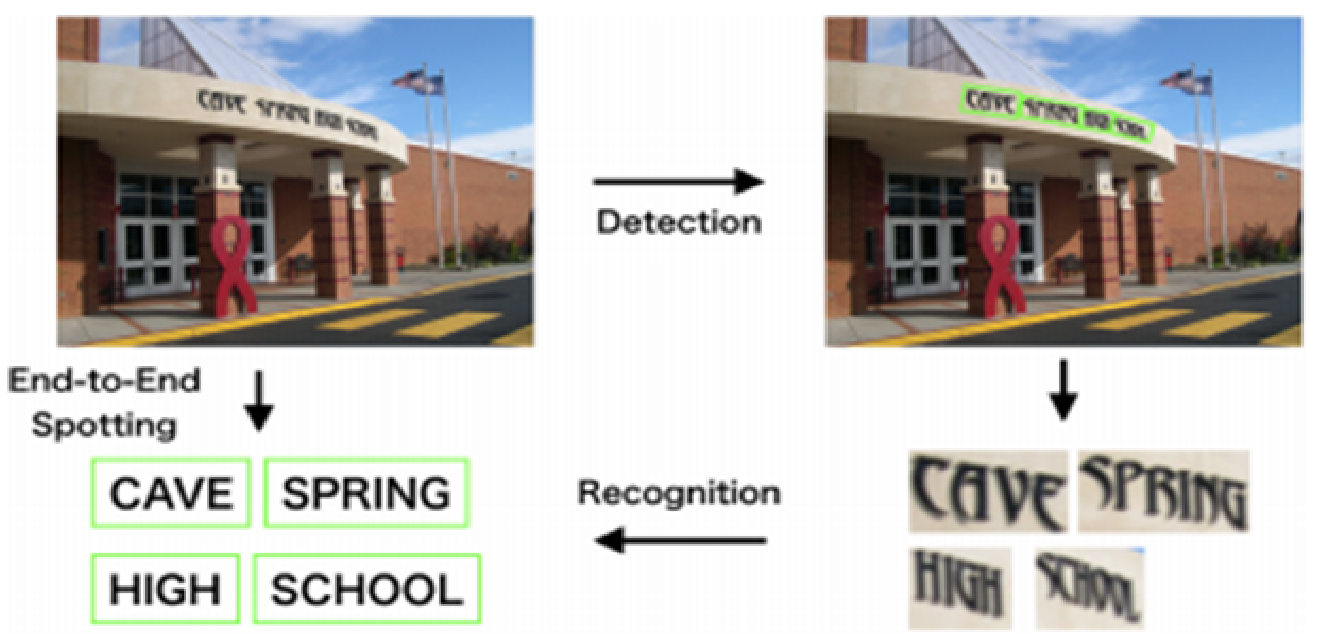

![STD.png](attachment:STD.png)

## 2. Problem Statement:

- The objective is to Detect Text from an Image, Draw a Bounding box around it, and Recognize that Text from and Image, and then do further processes with the image like Converting to another language..etc.

## 3. Business Objectives and Constraints:

<B>Business Objectives</B>
- Text Extraction.
- Text Recognition.
- Text Translation.

<B>Business Constraints</B>
- Low Latency requirement.
- Images are noisy, blurred.
- Text in the images is of diff colors.
- There may be objects in the image which may resemble a word or a character.

## 4. Data

- The dataset we’ll be using is from ICDAR 2015 Robust Reading Competition [https://rrc.cvc.uab.es/].
- The dataset consists of 1000 images for training, and another 500 images for testing.
- The text in this dataset is multi-oriented.
- The dataset consists of images which are noisy, blurred, which makes the dataset perfect for realtime application.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 5. Exploratory Data Analysis

In [1]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import pathlib
import re

from tqdm import tqdm

colab_path = '/content/drive/MyDrive/ICDAR_2015/'

In [2]:
def create_df(path):
    '''this function will create a dataframe for the train and test data'''
    
    new_img_path = path + 'images'
    imag = os.listdir(new_img_path)
    imag2 = []
    for i in imag:
        imag2.append(os.path.join(new_img_path, i))

    new_gt_path = path + 'ground_truth'
    gt = os.listdir(new_gt_path)
    gt2 = []
    for i in gt:
        gt2.append(os.path.join(new_gt_path, i))
        
    data = pd.DataFrame(list(zip(sorted(imag2), sorted(gt2))), columns = ['images', 'ground_truth'])
    return data

In [3]:
train_data = create_df(colab_path + 'train/')
test_data = create_df(colab_path + 'test/')

In [5]:
train_data.head()

,images,ground_truth
0,/content/drive/MyDrive/ICDAR_2015/train/images...,/content/drive/MyDrive/ICDAR_2015/train/ground...
1,/content/drive/MyDrive/ICDAR_2015/train/images...,/content/drive/MyDrive/ICDAR_2015/train/ground...
2,/content/drive/MyDrive/ICDAR_2015/train/images...,/content/drive/MyDrive/ICDAR_2015/train/ground...
3,/content/drive/MyDrive/ICDAR_2015/train/images...,/content/drive/MyDrive/ICDAR_2015/train/ground...
4,/content/drive/MyDrive/ICDAR_2015/train/images...,/content/drive/MyDrive/ICDAR_2015/train/ground...


In [6]:
train_data.shape #shape of the train dataframe

(1000, 2)

In [7]:
def get_height_width(data):
    '''this function will get heights and widths from a dataframe'''

    heights, widths = [], []
    for i in tqdm(data['images']):
        img = cv2.imread(i)
        # print(img.shape)
        width, height, depth = img.shape
        heights.append(height)
        widths.append(width)

    return heights, widths


In [10]:
train_heights, train_widths = get_height_width(train_data)
test_heights, test_widths = get_height_width(test_data)

100%|██████████| 500/500 [04:31<00:00,  1.84it/s]


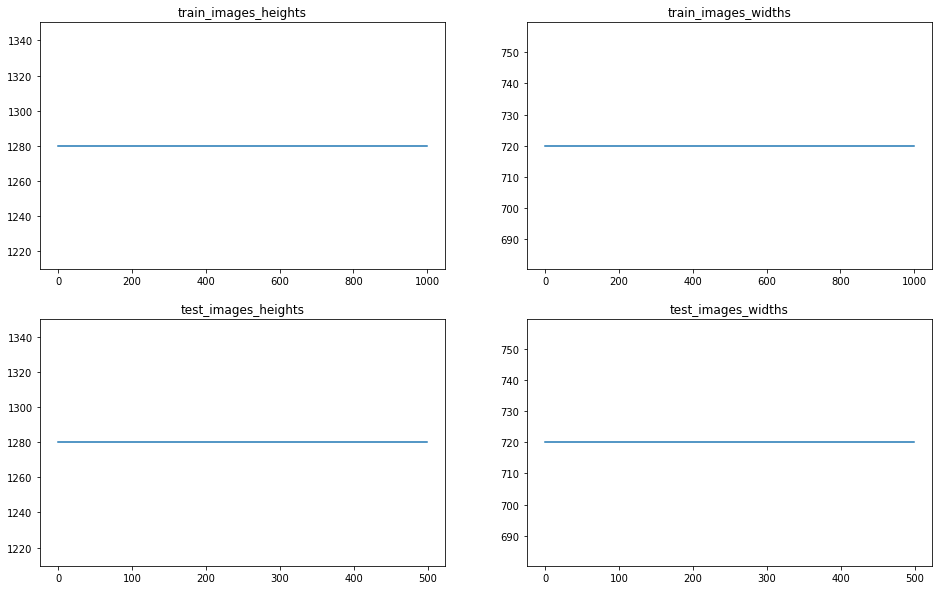

In [30]:
'''plotting heights and widths of train and test images'''

plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
plt.plot(train_heights)
plt.title("train_images_heights")

plt.subplot(2,2,2)
plt.plot(train_widths)
plt.title("train_images_widths")

plt.subplot(2,2,3)
plt.plot(test_heights)
plt.title("test_images_heights")

plt.subplot(2,2,4)
plt.plot(test_widths)
plt.title("test_images_widths")

plt.show()

<B>Observations</B>
- from the above plots we can see that heights of each images in train and test data are same.
- the width of train and test images are also same.



In [14]:
def get_bb_no(data):
    '''this function will calculate no of bounding boxes in an image, and calculate their heights and widths'''

    no_of_bb = []
    bb_heights = []
    bb_widths = []
    for i in tqdm(data['ground_truth']):
        file = open(i, encoding = 'utf-8-sig')
        files = file.readlines()
        no_of_bb.append(len(files))
        for lines in files:
            coords = lines.split(",")[:8]
            coords = list(map(int, coords))
            wid = np.sqrt((coords[3] - coords[0])**2 + (coords[4] - coords[2])**2) #calculating width
            hei = np.sqrt((coords[5] - coords[3])**2 + (coords[6] - coords[4])**2) #calculating height
            bb_heights.append(hei)
            bb_widths.append(wid)
        file.close()

    return no_of_bb, bb_heights, bb_widths


In [15]:
train_bbs, train_bb_heights, train_bb_widths = get_bb_no(train_data)
test_bbs, test_bb_heights, test_bb_widths = get_bb_no(test_data)

100%|██████████| 500/500 [04:30<00:00,  1.85it/s]


In [46]:
print("Total no of bounding boxes in train images: ", sum(train_bbs))
print("Total no of bounding boxes in test images: ", sum(test_bbs))

Total no of bounding boxes in train images:  11886
Total no of bounding boxes in test images:  5230


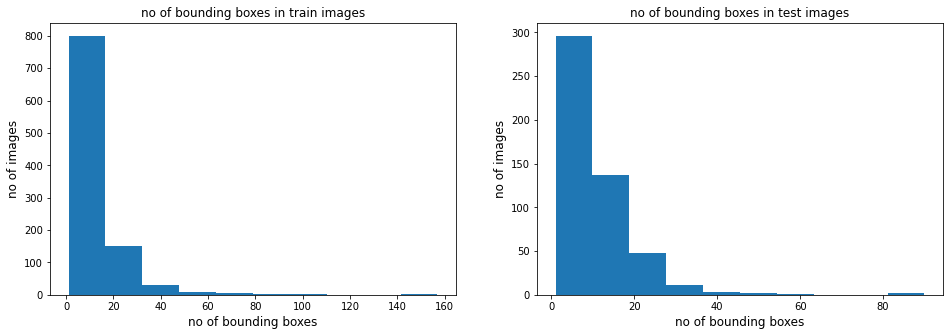

In [38]:
'''plotting histogram of no of bounding boxes in train and test images'''

plt.figure(figsize = (16,5))

plt.subplot(121)
plt.hist(train_bbs) #no of bounding boxes in train images
plt.title("no of bounding boxes in train images", fontsize = 12)
plt.xlabel("no of bounding boxes", fontsize = 12)
plt.ylabel("no of images", fontsize = 12)

plt.subplot(122)
plt.hist(test_bbs)  #no of bounding boxes in test images
plt.title("no of bounding boxes in test images", fontsize = 12)
plt.xlabel("no of bounding boxes", fontsize = 12)
plt.ylabel("no of images", fontsize = 12)

plt.show()

<B>Observations</B>
- from the above plots we can see that in train images most images contains between 1 - 18 bounding boxes.
- there are some images in train data which contains around 142 - 157 bounding boxes.
- in test images most images contains 1 - 10 bounding boxes.
- there are few images in test data which contains 82 - 92 bounding boxes.




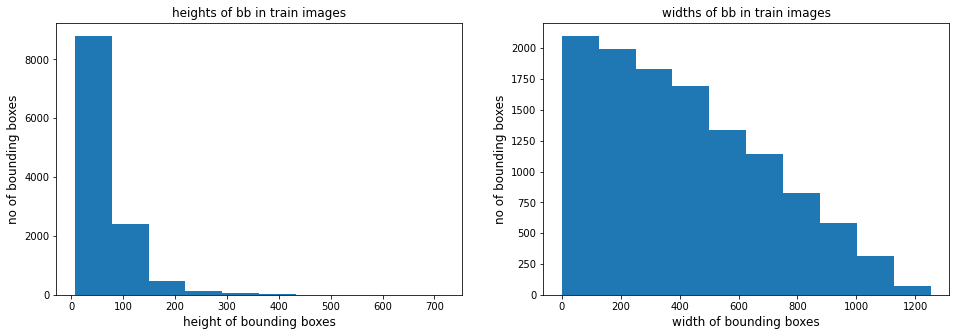

In [44]:
'''plotting histogram of heights and widths of bounding boxes in train images'''

plt.figure(figsize = (16,5))

plt.subplot(121)
plt.hist(train_bb_heights)
plt.title("heights of bb in train images", fontsize = 12)
plt.xlabel("height of bounding boxes", fontsize = 12)
plt.ylabel("no of bounding boxes", fontsize = 12)

plt.subplot(122)
plt.hist(train_bb_widths)
plt.title("widths of bb in train images", fontsize = 12)
plt.xlabel("width of bounding boxes", fontsize = 12)
plt.ylabel("no of bounding boxes", fontsize = 12)

plt.show()

<B>Observations</B>
- from the above lots we can see that most bounding boxes in train images have a height less than 80.
- some bounding boxes also has height greater than 300.
-  most bounding boxes in train images have a width less than 600.
- some bounding boxes also has width greater than 1200.





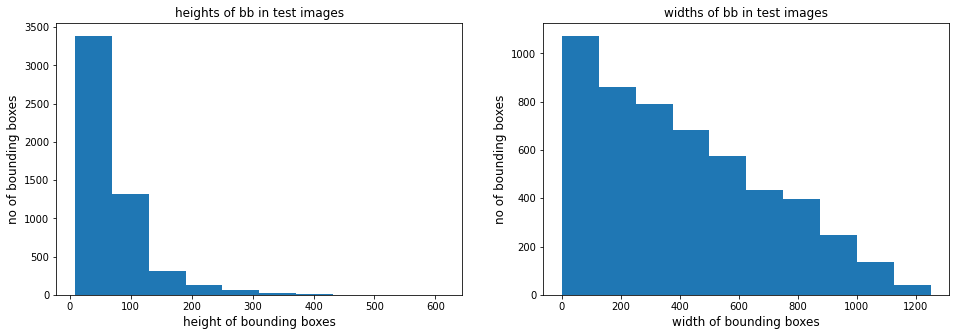

In [45]:
'''plotting histogram of heights and widths of bounding boxes in test images'''

plt.figure(figsize = (16,5))

plt.subplot(121)
plt.hist(test_bb_heights)
plt.title("heights of bb in test images", fontsize = 12)
plt.xlabel("height of bounding boxes", fontsize = 12)
plt.ylabel("no of bounding boxes", fontsize = 12)

plt.subplot(122)
plt.hist(test_bb_widths)
plt.title("widths of bb in test images", fontsize = 12)
plt.xlabel("width of bounding boxes", fontsize = 12)
plt.ylabel("no of bounding boxes", fontsize = 12)

plt.show()

<B>Observations</B>
- from the above lots we can see that most bounding boxes in test images have a height less than 80.
- some bounding boxes also has height greater than 300.
-  most bounding boxes in test images have a width less than 600.
- some bounding boxes also has width greater than 1200.



In [14]:
cv2.imread(train_data['images'][0]).shape #shape of images in the train data

(720, 1280, 3)

In [7]:
test_data.head()

,images,ground_truth
0,/content/drive/MyDrive/ICDAR_2015/test/images/...,/content/drive/MyDrive/ICDAR_2015/test/ground_...
1,/content/drive/MyDrive/ICDAR_2015/test/images/...,/content/drive/MyDrive/ICDAR_2015/test/ground_...
2,/content/drive/MyDrive/ICDAR_2015/test/images/...,/content/drive/MyDrive/ICDAR_2015/test/ground_...
3,/content/drive/MyDrive/ICDAR_2015/test/images/...,/content/drive/MyDrive/ICDAR_2015/test/ground_...
4,/content/drive/MyDrive/ICDAR_2015/test/images/...,/content/drive/MyDrive/ICDAR_2015/test/ground_...


In [8]:
test_data.shape #shape of test dataframe

(500, 2)

In [15]:
cv2.imread(test_data['images'][0]).shape #shape of images in test data

(720, 1280, 3)

In [4]:
train_data.head()

,images,ground_truth
0,/content/drive/MyDrive/ICDAR_2015/train/images...,/content/drive/MyDrive/ICDAR_2015/train/ground...
1,/content/drive/MyDrive/ICDAR_2015/train/images...,/content/drive/MyDrive/ICDAR_2015/train/ground...
2,/content/drive/MyDrive/ICDAR_2015/train/images...,/content/drive/MyDrive/ICDAR_2015/train/ground...
3,/content/drive/MyDrive/ICDAR_2015/train/images...,/content/drive/MyDrive/ICDAR_2015/train/ground...
4,/content/drive/MyDrive/ICDAR_2015/train/images...,/content/drive/MyDrive/ICDAR_2015/train/ground...


In [12]:
def extract_coordinates_and_text(path):
    '''this function will get coordinates and text from ground truth file, and also preprocess it'''

    file = open(path, encoding='utf-8-sig')
    file_items = file.readlines()
    coordinates = []
    text = []
    
    for lines in file_items: #iterating through each line in the file and preprocessing it
        lines_data = lines.lower()
        lines_data = re.sub("[\n\t\-\\\/]","", lines_data)
        lines_data = re.sub("[\[\]]", "", lines_data)
        line_split = lines_data.split(",")

        coords = line_split[:8]  #extracting coordinates and converting them to integer
        coords = list(map(int, coords))
        coordinates.append(coords)


        te_xt = line_split[8:] #extracting text
        if len(te_xt) >1:
            text.extend(",".join(te_xt))
        else:
            text.extend(te_xt)
    
    return coordinates, text

def get_coordinates_and_text(data):
    '''this function will pass ground truth filepath to extract_coordinates_and_text function
    and then will return dataframe'''

    coordinates = []
    text = []
    for i in tqdm(data['ground_truth']):
        coords, te_xt = extract_coordinates_and_text(i)

        coordinates.append(coords)
        text.append(te_xt)

    data['coordinates'] = coordinates
    data['text'] = text

    return data
# extract_coordinates_and_text(train_data['ground_truth'][0])

In [13]:
preprocessed_train_data = get_coordinates_and_text(train_data)
preprocessed_test_data = get_coordinates_and_text(test_data)

100%|██████████| 500/500 [00:00<00:00, 849.08it/s]


In [14]:
preprocessed_train_data.head()

,images,ground_truth,coordinates,text
0,/content/drive/MyDrive/ICDAR_2015/train/images...,/content/drive/MyDrive/ICDAR_2015/train/ground...,"[[377, 117, 463, 117, 465, 130, 378, 130], [49...","[genaxis theatre, 06, ###, 6203, carpark, ###,..."
1,/content/drive/MyDrive/ICDAR_2015/train/images...,/content/drive/MyDrive/ICDAR_2015/train/ground...,"[[261, 138, 284, 140, 279, 158, 260, 158], [28...","[###, harbourfront, cc22, bua, ###, ###, ###, ..."
2,/content/drive/MyDrive/ICDAR_2015/train/images...,/content/drive/MyDrive/ICDAR_2015/train/ground...,"[[645, 19, 686, 13, 692, 43, 651, 48], [689, 1...","[way, out, ###, line, platform, ###, ###, ###]"
3,/content/drive/MyDrive/ICDAR_2015/train/images...,/content/drive/MyDrive/ICDAR_2015/train/ground...,"[[486, 216, 554, 211, 558, 243, 489, 248], [1,...","[###, ###, ###, ###]"
4,/content/drive/MyDrive/ICDAR_2015/train/images...,/content/drive/MyDrive/ICDAR_2015/train/ground...,"[[899, 214, 928, 213, 928, 241, 900, 242], [93...","[care, sticker, for, ###, more, ###, ###, ###,..."


In [15]:
preprocessed_test_data.head()

,images,ground_truth,coordinates,text
0,/content/drive/MyDrive/ICDAR_2015/test/images/...,/content/drive/MyDrive/ICDAR_2015/test/ground_...,"[[933, 255, 954, 255, 956, 277, 936, 277], [17...","[###, ###, ###, ###, ###, ###, ###, ###]"
1,/content/drive/MyDrive/ICDAR_2015/test/images/...,/content/drive/MyDrive/ICDAR_2015/test/ground_...,"[[27, 17, 103, 22, 106, 47, 30, 45], [107, 20,...","[please, lower, your, volume, when, you, pass,..."
2,/content/drive/MyDrive/ICDAR_2015/test/images/...,/content/drive/MyDrive/ICDAR_2015/test/ground_...,"[[454, 115, 477, 115, 474, 130, 457, 132], [47...","[###, diverse, tastes, ###, flavours, the, ref..."
3,/content/drive/MyDrive/ICDAR_2015/test/images/...,/content/drive/MyDrive/ICDAR_2015/test/ground_...,"[[831, 115, 1003, 72, 1012, 171, 835, 195], [4...","[sale, marc, ###]"
4,/content/drive/MyDrive/ICDAR_2015/test/images/...,/content/drive/MyDrive/ICDAR_2015/test/ground_...,"[[615, 246, 698, 251, 694, 281, 615, 272], [69...","[st.marc, cafe, ###, ###]"


In [111]:
def clean_coordinates(coords):
    '''this function will convert coodinates from
    [377, 117, 463, 117, 465, 130, 378, 130] to [[377, 117], [463, 117], [465, 130], [378, 130]]'''
    
    new_coords = []
    for i in coords:
        co_ord = []
        for j in range(0, len(i), 2):
            co_ord.append((i[j], i[j+1]))
        new_coords.append(np.array(co_ord))
    return new_coords


def plottin(imag, coords, text):
    '''this function will create bounding box on top of image 
    and write text on top of the bounding box and return 
    orignal image and image with bounding box'''

    orig_imag = cv2.cvtColor(cv2.imread(imag), cv2.COLOR_BGR2RGB)
    coords = clean_coordinates(coords)
    text = np.array(text)
    imax = cv2.cvtColor(cv2.imread(imag), cv2.COLOR_BGR2RGB) #converting from BGR to RGB
                                    
    for i in range(len(coords)):
        co_ords = coords[i]
        # https://www.geeksforgeeks.org/python-opencv-cv2-polylines-method/
        imax_poly = cv2.polylines(imax, [co_ords], True,(0,255,255),thickness=3) #creating the bounding box

        x, y = co_ords[0][0], co_ords[0][1]  #getting the first coordinate of the bounding box
        (w,h) = cv2.getTextSize(text[i], cv2.FONT_HERSHEY_PLAIN, 1.5, 1)[0] #getting text size

        text_box = ((x,y), (x + w + 2, y - h - 2))

        #https://www.geeksforgeeks.org/python-opencv-cv2-rectangle-method/
        #https://www.geeksforgeeks.org/python-opencv-cv2-puttext-method/
        cv2.rectangle(imax_poly, text_box[0],text_box[1], (255, 255, 255), cv2.FILLED) #creating a box for writing text
        cv2.putText(imax_poly, text[i], (x,y), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 1) #adding text on top of the box

    return orig_imag, imax_poly

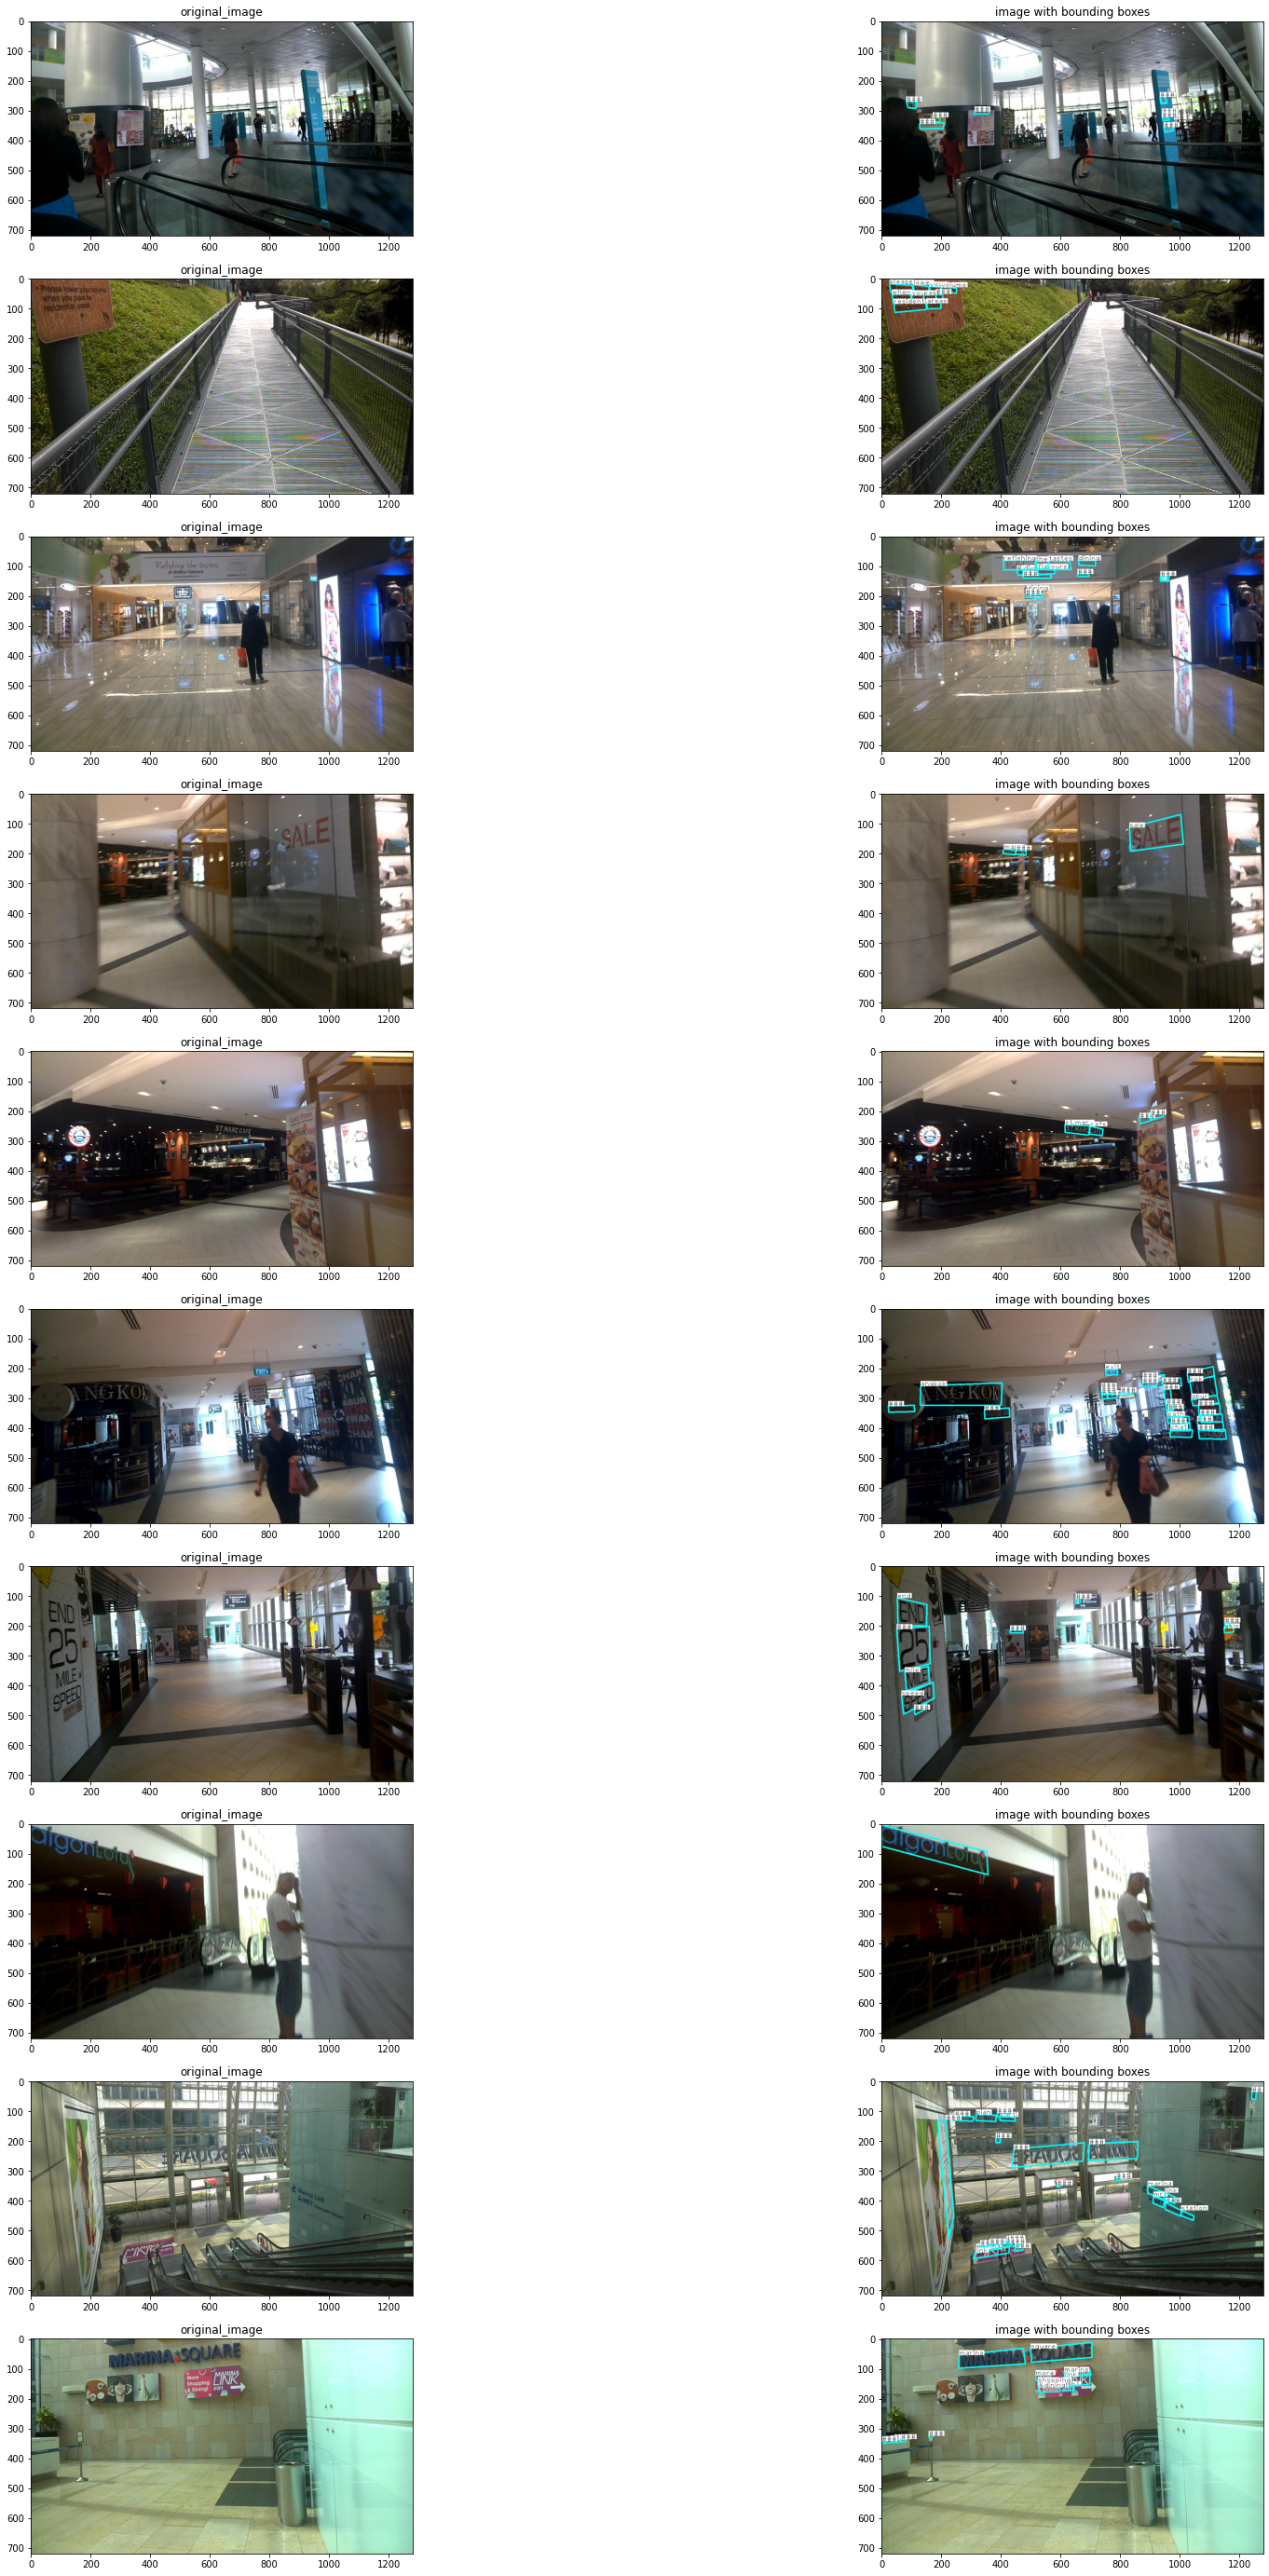

In [118]:
def images_with_And_without_bounding_boxes(num): #num = no of images from test data
    '''this function will plot images with and without bounding boxes'''

    plt.figure(figsize = (30,50))
    flag = 1
    for i in range(num):
        imagx = preprocessed_test_data['images'][i]
        coordsx = preprocessed_test_data['coordinates'][i]
        textx = preprocessed_test_data['text'][i]

        orig_img, image_with_bb = plottin(imagx, coordsx, textx)
        plt.subplot(num,2,flag)
        plt.title("original_image")
        plt.imshow(orig_img)
        flag += 1
        plt.subplot(num,2,flag)
        plt.title("image with bounding boxes")
        plt.imshow(image_with_bb)
        flag += 1

images_with_And_without_bounding_boxes(10)

<B>Conclusion</B>
- the heights and widths of all the images in train and test data are same
- the no of bounding boxes varies from images to images but most images contains less than 20 biunding boxes but some images also contains more than 80 bounding boxes.
- the heights of most bounding boxes is less than 80 but some also has height more than 300.
- the widths of most bounding boxes is less 600 than but some also has width more than 1200.